In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import torch

/home/makhlouf/miniconda3/envs/hbm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Test T-SNE with text embeddings

In [2]:
df = pd.read_pickle("features/twitterxlmrobertabase_text_embed_w_dum_data.p")

df_topic = pd.read_pickle("data/db_hbm/prepared_data_w_dum_data.p")

sample = []
label_keys = {
    "war": 0,
    "automotiveIndustry": 1,
    "corona": 2,
    "sport": 3,
    "politics": 4,
    "fun": 5,
    "history": 6,
    "economics": 7,
    "promotion": 8,
    "social": 9,
    "weather": 10,
    "technology": 11,
}

i = 0
while True:
    data = {"embedding": [], "topic": []}
    data["embedding"] = df[i]["tweet"]["last"]
    data["topic"] = label_keys[df_topic[i]["topic"][0]]
    i += 1
    sample.append(data)
    if i == 10:
        break
df_emb = pd.DataFrame(sample)

tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=3)
x_embedded = tsne.fit_transform(np.array(df_emb["embedding"].tolist()))


labels = df_emb["topic"].values


In [3]:
df_emb

,embedding,topic
0,"[-0.0149355065, 0.080913626, -0.026130466, 0.1...",2
1,"[0.047388706, 0.28239188, -0.041810587, 0.1827...",7
2,"[0.0060932348, 0.060832515, 0.03672339, 0.1356...",4
3,"[0.003682132, 0.014166594, -0.0028384367, 0.18...",0
4,"[0.020934131, 0.0474295, -0.02196019, 0.107017...",0
5,"[-0.05916507, 0.05486989, -0.004878062, 0.1912...",10
6,"[-0.09864283, 0.084024444, 0.008162607, 0.2662...",10
7,"[0.030666424, 0.077708006, -0.013923808, 0.205...",2
8,"[0.010617413, 0.042304594, -0.023366237, 0.203...",4
9,"[-0.059887633, 0.055527482, -0.030296883, 0.21...",4


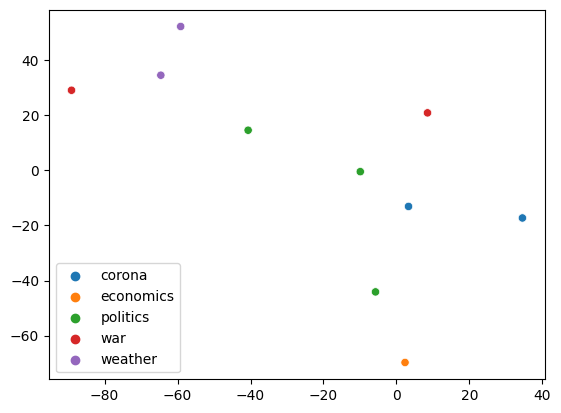

In [4]:
label_topics = [list(label_keys.keys())[x] for x in labels]

# sns.scatterplot(
#     x=df_emb["embedding"].values,
#     y=labels,
#     data=x_embedded,
# )
g = sns.scatterplot(
    x=x_embedded[:, 0],
    y=x_embedded[:, 1],
    hue=label_topics,
)

# plt.legend()
plt.show()

### T-SNE with HBMNet before Classification Layer Embeddings

In [5]:
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
def get_hbmnet_att_embds(model, vfeat, tfeat):
    
    x1 = model.tweet_vdp1(
            model.relu(model.tweet_vbn1(model.tweet_vfc1(vfeat["tweet"].to(model.device))))
        )
    x2 = model.tweet_tdp1(
        model.relu(model.tweet_tbn1(model.tweet_tfc1(tfeat["tweet"].to(model.device))))
    )
    tweet_x = torch.cat((x1, x2), axis=1)

    return tweet_x


In [7]:
# def get_hbmnet_att_embds(model, vfeat, tfeat):
    
#     x1 = model.tweet_vdp1(
#             model.relu(model.tweet_vbn1(model.tweet_vfc1(vfeat["tweet"].to(model.device))))
#         )
#     x2 = model.tweet_tdp1(
#         model.relu(model.tweet_tbn1(model.tweet_tfc1(tfeat["tweet"].to(model.device))))
#     )
#     tweet_x = torch.cat((x1, x2), axis=1)
#     tweet_x = model.tweet_dp2(model.relu(model.tweet_bn2(model.tweet_fc2(tweet_x))))

#     reply_x_list = []
#     for i, _ in enumerate(tfeat["replies"]):
#         x1 = model.reply_vdp1(
#             model.relu(
#                 model.reply_vbn1(
#                     model.reply_vfc1(vfeat["replies"][i].to(model.device))
#                 )
#             )
#         )
#         x2 = model.reply_tdp1(
#             model.relu(
#                 model.reply_tbn1(
#                     model.reply_tfc1(tfeat["replies"][i].to(model.device))
#                 )
#             )
#         )
#         x3 = torch.cat((x1, x2), axis=1)
#         x3 = model.reply_dp2(model.relu(model.reply_bn2(model.reply_fc2(x3))))
#         w = tfeat["replies_indices"][:, i].unsqueeze(dim=1).to(model.device)
#         x3 = x3 * w
#         reply_x_list.append(x3)

#     reply_x = torch.stack(tensors=reply_x_list, dim=1)
#     reply_x, weights = model.reply_att(
#         query=tweet_x.unsqueeze(dim=1),
#         context=reply_x,
#         context_mask=tfeat["replies_indices"].to(model.device),
#     )
#     reply_x = reply_x.squeeze()
#     reply_x = model.reply_dp3(model.relu(model.reply_bn3(model.reply_fc3(reply_x))))

#     quote_x_list = []
#     for i, _ in enumerate(tfeat["quotes"]):
#         x1 = model.quote_vdp1(
#             model.relu(
#                 model.quote_vbn1(model.quote_vfc1(vfeat["quotes"][i].to(model.device)))
#             )
#         )
#         x2 = model.quote_tdp1(
#             model.relu(
#                 model.quote_tbn1(model.quote_tfc1(tfeat["quotes"][i].to(model.device)))
#             )
#         )
#         x3 = torch.cat((x1, x2), axis=1)
#         x3 = model.quote_dp2(model.relu(model.quote_bn2(model.quote_fc2(x3))))
#         w = tfeat["quotes_indices"][:, i].unsqueeze(dim=1).to(model.device)
#         x3 = x3 * w
#         quote_x_list.append(x3)

#     quote_x = torch.stack(tensors=quote_x_list, dim=1)
#     quote_x, weights = model.quote_att(
#         query=tweet_x.unsqueeze(dim=1),
#         context=quote_x,
#         context_mask=tfeat["quotes_indices"].to(model.device),
#     )
#     quote_x = quote_x.squeeze()
#     quote_x = model.quote_dp3(model.relu(model.quote_bn3(model.quote_fc3(quote_x))))

#     x = torch.cat((tweet_x, reply_x, quote_x), axis=1)

#     return x


In [8]:
from utils import init_experiment
from data import HBMDataset

img_feat_type = "feats"
img_model_type = "imagenet"
txt_model_type = "twitterxlmrobertabase"
txt_feat_type = "sumavg"
# smooth = args.smooth

config_path = "configs/config_hbmnet_baseline_tv.yaml"

cfg = init_experiment(config_path=config_path)

exp_name = cfg.exp_name

train_val_set = HBMDataset(
    data_path=cfg.data.data_path,
    txt_feat_path=cfg.data.txt_feat_path,
    img_feat_path=cfg.data.img_feat_path,
    normalize=cfg.data.normalize,
    txt_model_type=txt_model_type,
    img_model_type=img_model_type,
    txt_feat_type=txt_feat_type,
    img_feat_type=img_feat_type,
    split="train/val",
    val_percent=cfg.data.val_percent,
    test_percent=cfg.data.test_percent,
    limit_n_replies=cfg.data.limit_n_replies,
    limit_n_quotes=cfg.data.limit_n_quotes,
    use_img_feat=cfg.data.use_img_feat,
    use_like_feat=cfg.data.use_like_feat,
    multilabel=cfg.training.multilabel,
)


In [9]:
gpu = 2
device = torch.device(f"cuda:{gpu}" if torch.cuda.is_available() else "cpu")

In [10]:
from models import HBMNetAtt
from models import HBMNetTV
from models import HBMNet
    
# model = HBMNetAtt(
#     vdim=train_val_set.vdim,
#     tdim=train_val_set.tdim,
#     nclasses=train_val_set.get_n_classes(),
#     device=device,
# )
model = HBMNetTV(
    vdim=train_val_set.vdim,
    tdim=train_val_set.tdim,
    nclasses=train_val_set.get_n_classes(),
    device=device,
)
# change trained model
model_path = "/home/makhlouf/train_LMETA/exps/098_hbmnet_tv/2/checkpoints/hbmnet_imagenet_feats_twitterxlmrobertabase_sumavg_final.pt"

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

HBMNetTV(
  (tweet_vfc1): Linear(in_features=2048, out_features=128, bias=True)
  (tweet_tfc1): Linear(in_features=768, out_features=128, bias=True)
  (tweet_vbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tweet_tbn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tweet_vdp1): Dropout(p=0.8, inplace=False)
  (tweet_tdp1): Dropout(p=0.8, inplace=False)
  (relu): ReLU()
  (cf): Linear(in_features=256, out_features=12, bias=True)
)

In [11]:
from sklearn.model_selection import KFold, StratifiedKFold

kfold = StratifiedKFold(
    n_splits=cfg.training.cv.k_folds, shuffle=True, random_state=seed
)
folds = [next(kfold.split(train_val_set, train_val_set.labels_str)) for i in range(cfg.training.cv.k_folds)]

In [12]:
from utils import worker_init_fn

fold = 2
train_ids, val_ids = folds[fold]

# train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
# val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)

# trainloader = torch.utils.data.DataLoader(
#     train_val_set,
#     batch_size=cfg.data.batch_size,
#     sampler=train_sampler,
#     pin_memory=False,
#     shuffle=False,
#     worker_init_fn=worker_init_fn,
# )
# valloader = torch.utils.data.DataLoader(
#     train_val_set,
#     batch_size=cfg.data.batch_size,
#     sampler=val_sampler,
#     pin_memory=False,
#     shuffle=False,
#     worker_init_fn=worker_init_fn,
# )

trainvalloader = torch.utils.data.DataLoader(
    train_val_set,
    batch_size=cfg.data.batch_size,
    pin_memory=False,
    shuffle=False,
    worker_init_fn=worker_init_fn,
)

In [13]:
def reduce_dimensions(dataloader):

    with torch.no_grad():
        embds_list = []
        labels_list = []
        for sample in dataloader:
            embds = get_hbmnet_att_embds(model, sample["vfeat"], sample["tfeat"])
            embds_list.append(embds)
            labels_list.append(sample["label"])
    
    embds = torch.cat(embds_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    
    tsne = TSNE(n_components=2, learning_rate="auto", init="random", perplexity=3)
    embds_reduced = tsne.fit_transform(embds.cpu().detach().numpy())

    return embds_reduced, labels

In [14]:
def plot_embds(embds_reduced, labels, title, figsize=(12, 10)):

    label_topics = [list(label_keys.keys())[x] for x in labels]

    color_dict = {
        "war": "red",
        "automotiveIndustry": "blue",
        "corona": "black",
        "sport": "gold",
        "politics": "magenta",
        "fun": "cyan",
        "history": "darksalmon",
        "economics": "grey",
        "promotion": "purple",
        "social": "lime",
        "weather": "green",
        "technology": "deepskyblue",
    }

    plt.figure(figsize=figsize)
    plt.title(title)
    ax = sns.scatterplot(
        x=embds_reduced[:, 0],
        y=embds_reduced[:, 1],
        hue=label_topics,
        palette=color_dict,
    )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    plt.show()

In [15]:
# train_embds_reduced, train_labels = reduce_dimensions(trainloader)

In [16]:
# val_embds_reduced, val_labels = reduce_dimensions(valloader)

In [17]:
embds_reduced, labels = reduce_dimensions(trainvalloader)

In [18]:
train_embds_reduced, train_labels = embds_reduced[train_ids], labels[train_ids]
val_embds_reduced, val_labels = embds_reduced[val_ids], labels[val_ids]

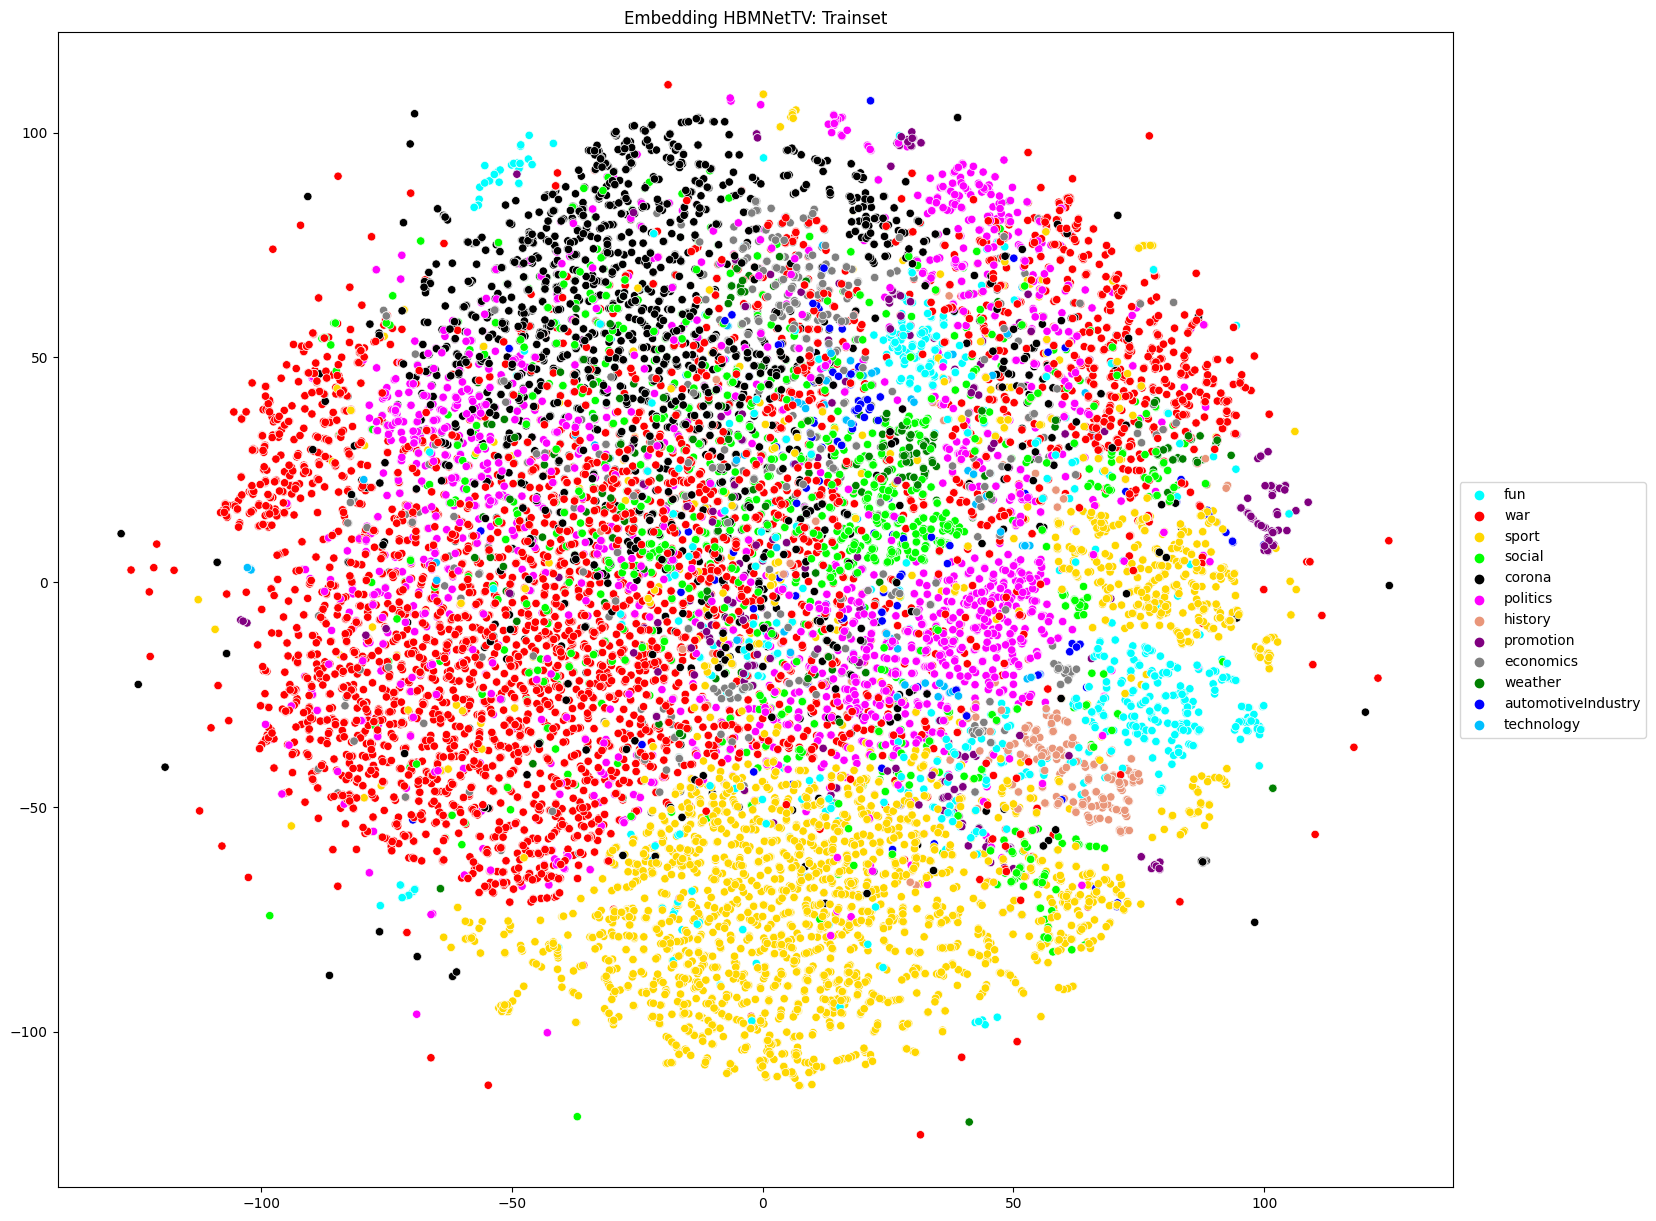

In [19]:
plot_embds(train_embds_reduced, train_labels, title="Embedding HBMNetTV: Trainset", figsize=(18, 15))

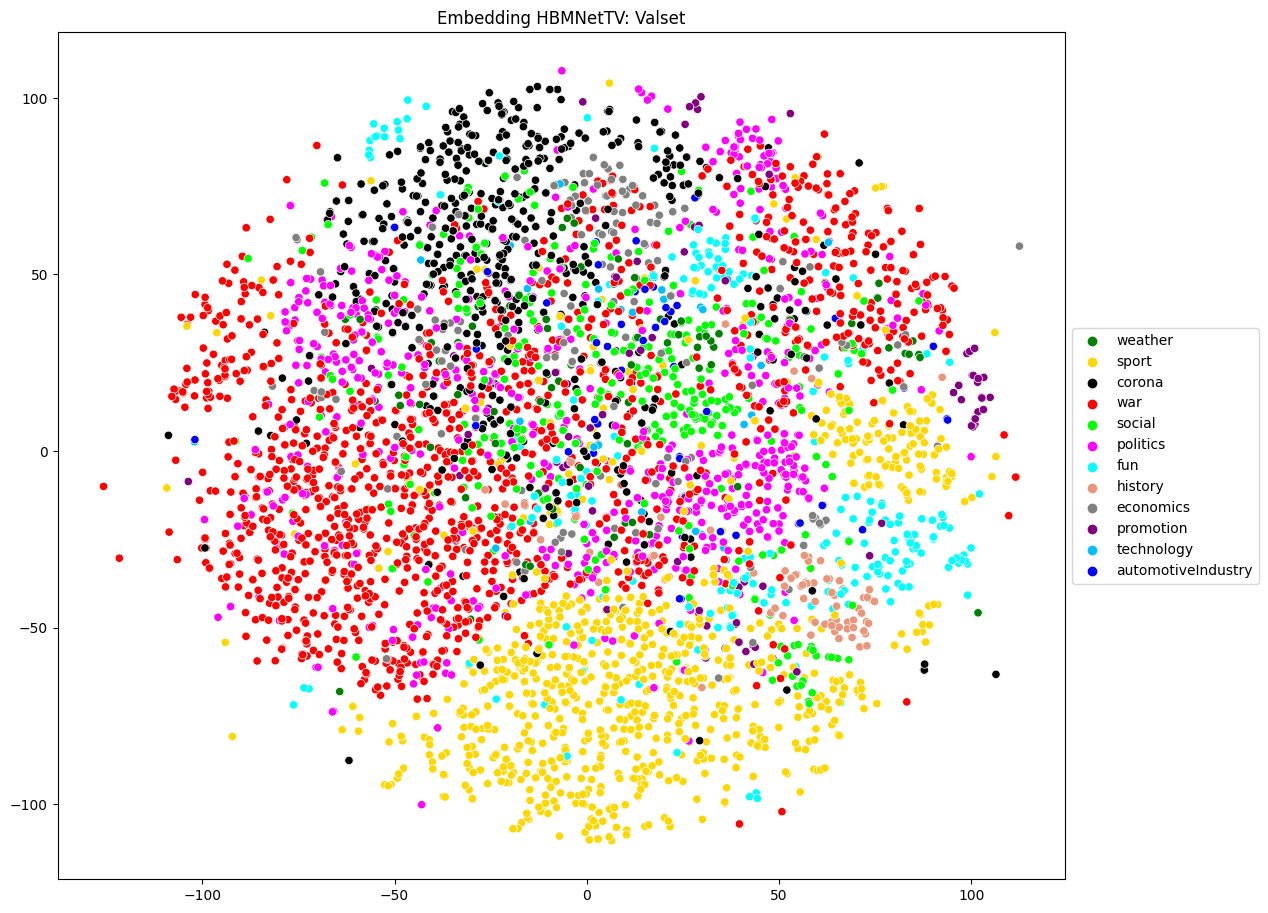

In [20]:
plot_embds(val_embds_reduced, val_labels, title="Embedding HBMNetTV: Valset", figsize=(13, 11))